# All Sites Random Forest: Unloading Paper
# Updated Analysis Random Forest Run
## Reruning the random forest model and taking a closer look at the decision trees in the ensemble

### We are creating a v2 of this file because we are having package and environment dependency issues. 
* So let's rerun this script, then resave the model at the end to load it later

created by Cassie Lumbrazo\
date: April 2024\
previously on the linux box, python environment: **raster**, using raster for now\
now, the python environment locally: **random_forest**, which I created just for this to try and resolve some package issues to get this plotting again.\
Pray for my package issues... 

Now, on the UAS linux machine.. and creating a new environment `randomforest`


In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr

import copy 
import pickle
import os

In [2]:
import graphviz

# this is not working, going to try one more thing before I cry 

import pygraphviz
# import python-graphviz
import pydot
import pydotplus

# I installed those two, and maybe you need them now with new versions...... 

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import pydotplus 
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

### Load the data

In [4]:
pwd

'/home/cassie/python/repos/unloading_regimes_analysis/random_forest_analysis'

In [41]:
# local_path = "/Users/Lumbr/OneDrive - UW/Documents/Washington/UnloadingRegimes/Python/"
local_path='/home/cassie/data/unloading_regimes_analysis/'

In [42]:
df_unload = pd.read_csv(local_path + "allsites_snowunload.csv")
df_unload.head()

datetime  shortwave  longwave  windspeed      RH   temp    A  \
0  2016-10-06 06:00:00       4.93   297.470      1.180  96.650 -3.495  1.0   
1  2016-10-06 07:00:00      29.43   298.655      1.735  93.195 -3.325  1.0   
2  2016-10-06 08:00:00     124.50   309.965      2.080  83.190 -2.430  1.0   
3  2016-10-06 09:00:00     102.04   306.465      2.745  90.135 -3.250  1.0   
4  2016-10-06 10:00:00     614.38   240.145      4.595  80.390 -3.350  1.0   

     B   CD    E  Type Class Snow      Sunlit Classification  Typesymbol  \
0  0.0  1.0  0.0   NaN   NaN  NaN  Not Sunlit   Snow Staying       128.0   
1  0.0  1.0  0.0   NaN   NaN  NaN  Not Sunlit   Snow Staying       128.0   
2  0.0  1.0  0.0   NaN   NaN  NaN  Not Sunlit   Snow Staying       128.0   
3  0.0  1.0  0.0   NaN   NaN  NaN  Not Sunlit   Snow Staying       128.0   
4  1.0  1.0  0.0   NaN   NaN  NaN  Not Sunlit   Snow Staying       128.0   

   Snowsymbol   site  pressure  snowdepth  
0       128.0  niwot       NaN        NaN  
1       128.0  niwot       NaN        NaN  
2       128.0  niwot       NaN        NaN  
3       128.0  niwot       NaN        NaN  
4       128.0  niwot       NaN        NaN

In [43]:
df_unload.Classification.value_counts()

Classification
Snow Staying      1288
Snow Unloading     446
Name: count, dtype: int64

## I want to flip the 0 and 1 values for unloading and staying....\
This is to help interpret the PDP plots because they are currently going the wrong direction. 

In [64]:
df_unload_og = copy.deepcopy(df_unload)  # make a copy of the original dataframe

# Random Forest

### Prepare the dataset for Random Forest

In [65]:
# cannot have any nans for random forest... so let's start by deleting columns we do not need 
df_int = df_unload.copy(deep=True)
df_int = df_int.drop(columns=['datetime', 'longwave', 'RH', 'pressure', 'snowdepth']) # the major ones

# also drop the ones that are not important right now 
df_int = df_int.drop(columns=['A','B','E','Type','Class','Snow', 'Sunlit', 'Typesymbol', 'Snowsymbol'])

# Saving this simplified dataframe for use later 
df_int_sites = (df_int.copy(deep=True)).dropna()

In [66]:
df_int['unload'] = 100
# df_int['unload'] = np.where(df_int['Classification'] == 'Snow Staying', 1, df_int['unload']) 
# df_int['unload'] = np.where(df_int['Classification'] == 'Snow Unloading', 0, df_int['unload'])

df_int['unload'] = np.where(df_int['CD'] == 0, 1, df_int['unload']) # now, 0 is snow staying, and 1 is snow unloading 
df_int['unload'] = np.where(df_int['CD'] == 1, 0, df_int['unload'])
# df_int.drop(columns=['Classification'], inplace=True)  # drop the original classification column

# and make a new one based on the unload column
df_int['classification'] = np.where(df_int['unload'] == 0, 'snow staying', 'snow unloading')
df_int

shortwave  windspeed      temp   CD  Classification   site  unload  \
0       4.930000   1.180000 -3.495000  1.0    Snow Staying  niwot       0   
1      29.430000   1.735000 -3.325000  1.0    Snow Staying  niwot       0   
2     124.500000   2.080000 -2.430000  1.0    Snow Staying  niwot       0   
3     102.040000   2.745000 -3.250000  1.0    Snow Staying  niwot       0   
4     614.380000   4.595000 -3.350000  1.0    Snow Staying  niwot       0   
...          ...        ...       ...  ...             ...    ...     ...   
1729  400.306250   0.770125  2.143021  1.0    Snow Staying  laret       0   
1730  605.846250   0.973554  3.865325  1.0    Snow Staying  laret       0   
1731  854.292500   1.648042  4.049008  0.0  Snow Unloading  laret       1   
1732  902.823333   1.427383  4.768171  0.0  Snow Unloading  laret       1   
1733  948.237500   1.719404  4.717921  0.0  Snow Unloading  laret       1   

      classification  
0       snow staying  
1       snow staying  
2       snow staying  
3       snow staying  
4       snow staying  
...              ...  
1729    snow staying  
1730    snow staying  
1731  snow unloading  
1732  snow unloading  
1733  snow unloading  

[1734 rows x 8 columns]

In [67]:
df_int.classification.value_counts()

classification
snow staying      1288
snow unloading     446
Name: count, dtype: int64

In [68]:
df_int = df_int.drop(columns=['Classification', 'site', 'classification', 'CD'])
df_int = df_int.dropna()
df_int.head()

shortwave  windspeed   temp  unload
0       4.93      1.180 -3.495       0
1      29.43      1.735 -3.325       0
2     124.50      2.080 -2.430       0
3     102.04      2.745 -3.250       0
4     614.38      4.595 -3.350       0

In [69]:
df_int = df_int.astype(int)
df_int.dtypes

shortwave    int64
windspeed    int64
temp         int64
unload       int64
dtype: object

In [70]:
# nametemperature = "air temperature (℃)"
# namewindspeed = "wind speed (ms⁻¹)"
# nameshortwave = "shortwave radiation (Wm⁻²)"

nametemperature = "air temperature (C)"
namewindspeed = "wind speed (m/s)"
nameshortwave = "shortwave radiation (W/m2)"

In [71]:
# rename the columns to be the full variable names for plotting later 
df_int.rename(columns={
    'shortwave': 'shortwave radiation (W/m2)',
    'temp': 'air temperature (C)',
    'windspeed': 'wind speed (m/s)',
    'unload': 'unloading'
}, inplace=True)

df_int

shortwave radiation (W/m2)  wind speed (m/s)  air temperature (C)  \
0                              4                 1                   -3   
1                             29                 1                   -3   
2                            124                 2                   -2   
3                            102                 2                   -3   
4                            614                 4                   -3   
...                          ...               ...                  ...   
1729                         400                 0                    2   
1730                         605                 0                    3   
1731                         854                 1                    4   
1732                         902                 1                    4   
1733                         948                 1                    4   

      unloading  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
1729          0  
1730          0  
1731          1  
1732          1  
1733          1  

[1650 rows x 4 columns]

In [72]:
# df_int['unloading'] =        df_int['unloading'].astype(int)
# df_int['air temperature (C)'] =      df_int['air temperature (C)'].astype(int)
# df_int['shortwave radiation (W/m2)'] = df_int['shortwave radiation (W/m2)'].astype(int)
# df_int['wind speed (m/s)'] = df_int['wind speed (m/s)'].astype(int)

# df_int.head()

In [73]:
# Finally, we can start the random forest analysis 
# first, we need to split the data into training and testing sets

# create the x, variables, columns
X = df_int.drop(columns=['unloading'])
X.head()

shortwave radiation (W/m2)  wind speed (m/s)  air temperature (C)
0                           4                 1                   -3
1                          29                 1                   -3
2                         124                 2                   -2
3                         102                 2                   -3
4                         614                 4                   -3

In [74]:
# create the y, predictor, column
y = df_int['unloading']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: unloading, dtype: int64

In [75]:
# x.describe()
X.isnull().values.any()
y.isnull().values.any()

np.False_

## Start with a Single Decision Tree 
to test that our dataset is setup properly

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=3)
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
print('Accuracy on train data is %.2f' % (accuracy_score(y_train, y_pred_train)))

y_pred_test = clf.predict(X_test)
print('Accuracy on test data is %.2f' % (accuracy_score(y_test, y_pred_test)))

dot_data = tree.export_graphviz(clf, feature_names=X.columns, filled=True, 
                                out_file=None) 
# graph = pydotplus.graph_from_dot_data(dot_data) 
# Image(graph.create_png())

Accuracy on train data is 0.82
Accuracy on test data is 0.84


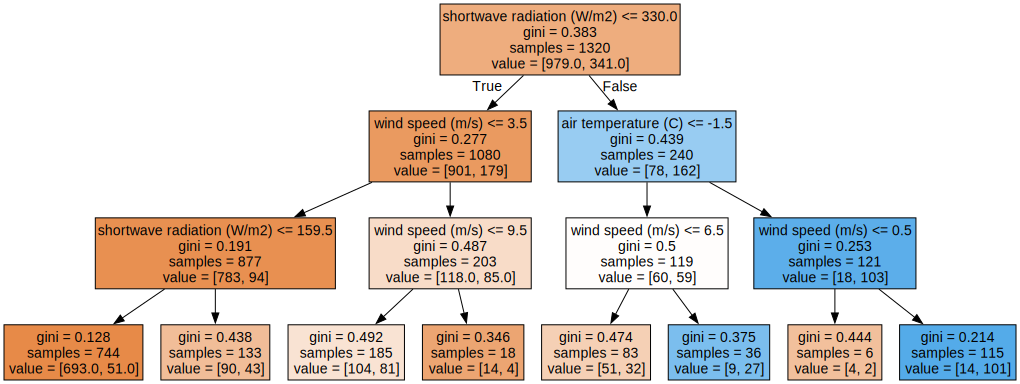

In [77]:
graph = graphviz.Source(dot_data)
graph

## Now, Random Forest

In [78]:
number_model_runs = 1000 # for all random forest runs 

In [79]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=0)

parameters = {'n_estimators': [number_model_runs], 'max_depth':[3]} 
clf1 = GridSearchCV(ensemble.RandomForestClassifier(n_jobs=15), parameters) 

# trying to write it like this to get the n_jobs parameter to work 
# clf1  = ensemble.RandomForestClassifier(n_estimators=30, max_depth=3, n_jobs=4)

clf1.fit(X=X_train1,y=y_train1.values.ravel())
tree_model1 = clf1.best_estimator_ # only the GridSearchCV has the object "best_estimator_"

y_pred_train1 = tree_model1.predict(X_train1)
y_pred_test1 = tree_model1.predict(X_test1)
print('Accuracy on training data is %.2f' % (accuracy_score(y_train1, y_pred_train1)))
print('Accuracy on test data is %.2f' % (accuracy_score(y_test1, y_pred_test1)))
print(clf1.best_params_)

Accuracy on training data is 0.83
Accuracy on test data is 0.85
{'max_depth': 3, 'n_estimators': 1000}


In [80]:
estimatorAccuracy=[]
for curEstimator in range(number_model_runs):
    estimatorAccuracy.append([curEstimator,accuracy_score(y.values, tree_model1.estimators_[curEstimator].predict(X.values))])

estimatorAccuracy=pd.DataFrame(estimatorAccuracy,columns=['estimatorNumber','Accuracy'])
estimatorAccuracy.sort_values(inplace=True,by='Accuracy',ascending=False)

bestDecisionTree1= tree_model1.estimators_[estimatorAccuracy.head(1)['estimatorNumber'].values[0]]

### And, take a look at the first decision tree

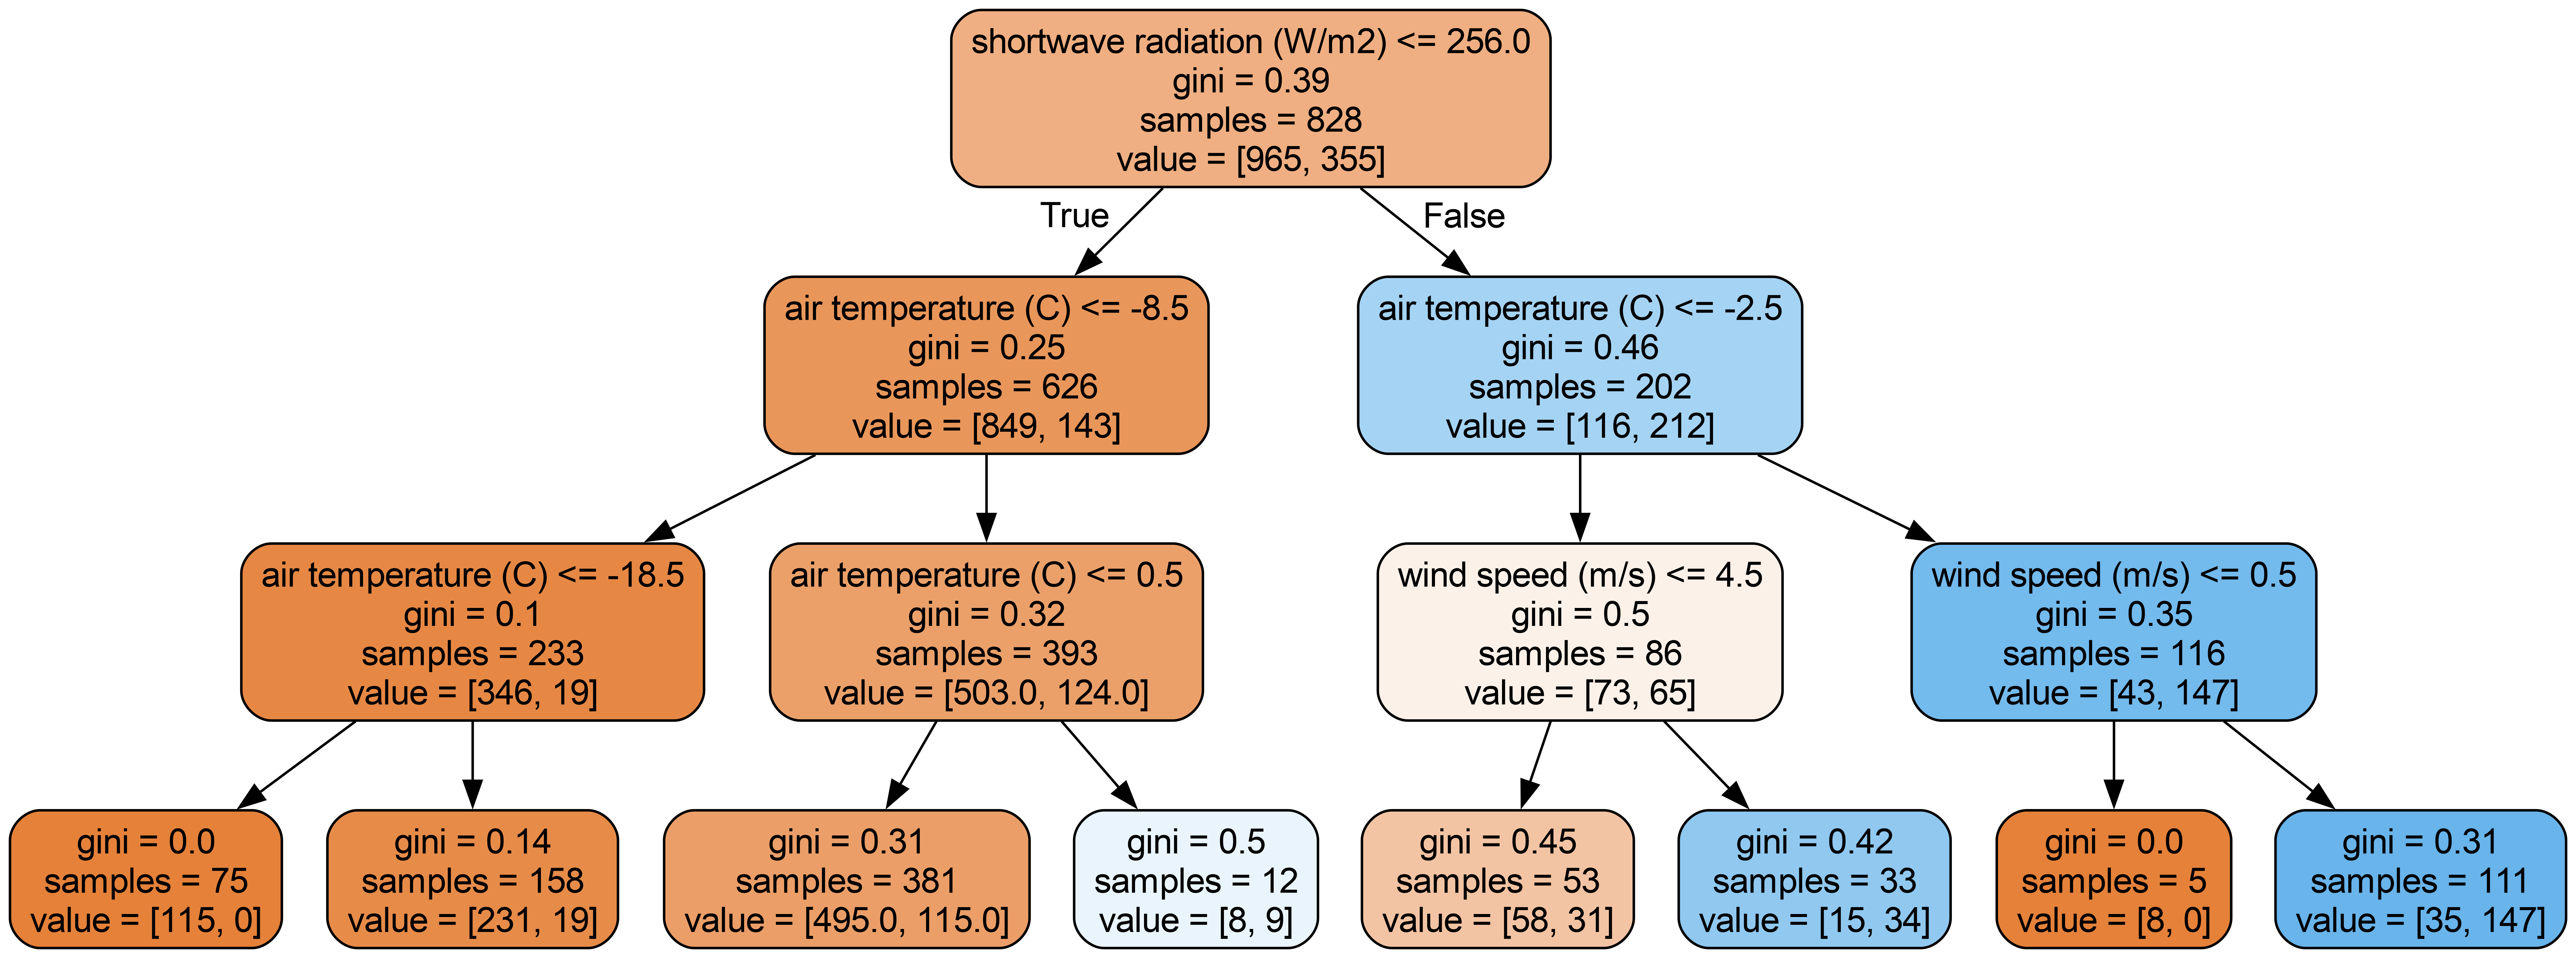

In [81]:
tree.export_graphviz(bestDecisionTree1, out_file='ensemble_tree1.dot', 
                feature_names = X.columns,
                # class_names = ('no_veg', 'veg'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'ensemble_tree1.dot', '-o', 'ensemble_tree1.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'ensemble_tree1.png')

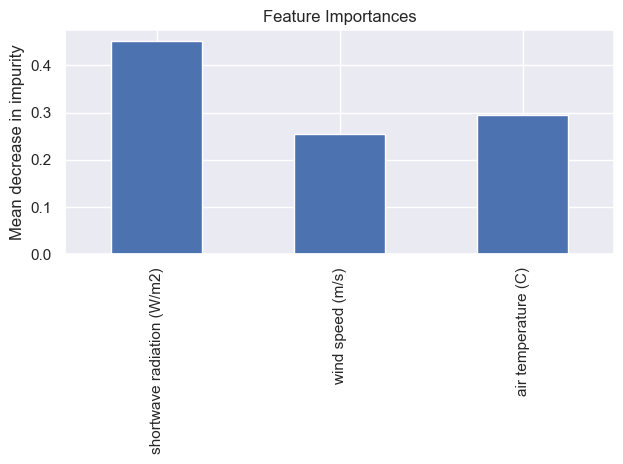

In [82]:
# Feature Importance 
importances1 = tree_model1.feature_importances_
std1 = np.std([tree_model1.feature_importances_ for tree in tree_model1.estimators_], axis=0)

forest_importances1 = pd.Series(importances1, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances1.plot.bar(yerr=std1, ax=ax)
ax.set_title("Feature Importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Visualize the decision trees and accuracy scores

In [83]:
estimatorAccuracy

estimatorNumber  Accuracy
739              739  0.834545
306              306  0.833333
392              392  0.831515
961              961  0.831515
157              157  0.830909
..               ...       ...
806              806  0.759394
469              469  0.755152
408              408  0.752121
964              964  0.749697
268              268  0.733333

[1000 rows x 2 columns]

### Plot the Accuracy of the Decision Trees to see how many perform well... 

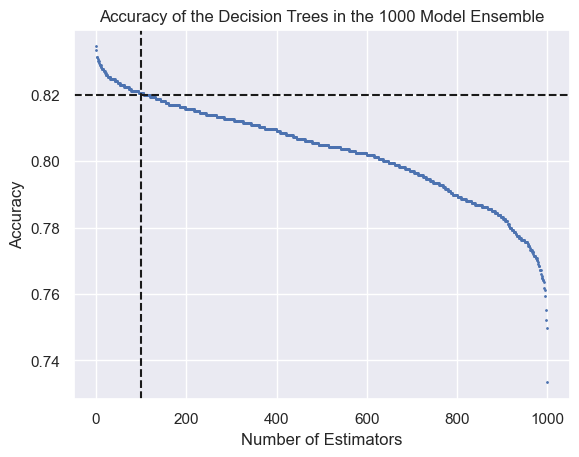

In [84]:
# make a plot of the estimator accuracy in order of highest accuracy 
plt.plot(estimatorAccuracy['Accuracy'].sort_values(ascending=False).values, marker='o', linestyle='None', markersize=1)
plt.title('Accuracy of the Decision Trees in the 1000 Model Ensemble')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')

# plot a verticle line at 100
plt.axvline(x=100, color='k', linestyle='--')
plt.axhline(y=0.82, color='k', linestyle='--')


(0.82, 0.835)

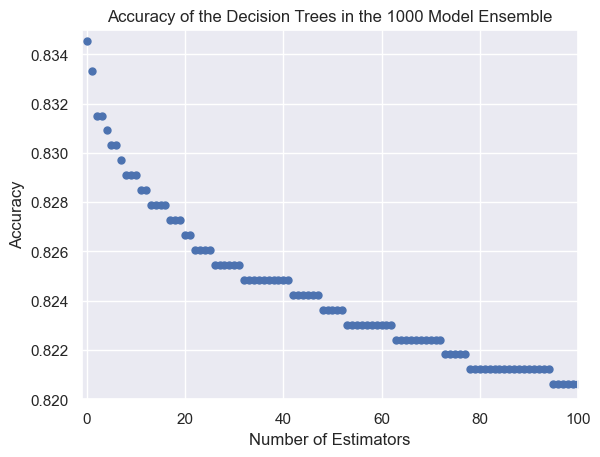

In [85]:
# make a plot of the estimator accuracy in order of highest accuracy 
plt.plot(estimatorAccuracy['Accuracy'].sort_values(ascending=False).values, marker='o', linestyle='None', markersize=5)
plt.title('Accuracy of the Decision Trees in the 1000 Model Ensemble')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')

# zoom into the xaxis 
plt.xlim(-1, 100)
plt.ylim(0.82, 0.835)

(0.83, 0.835)

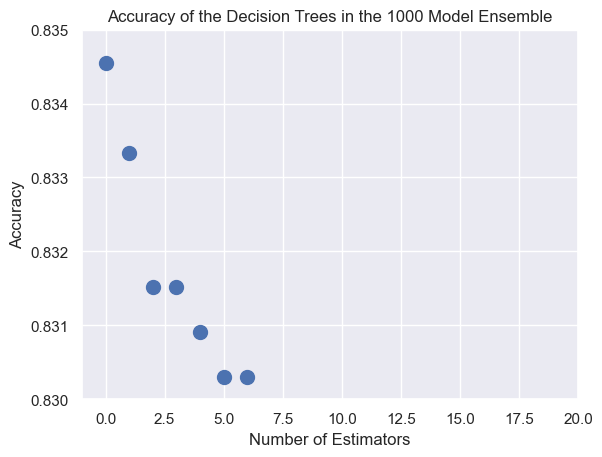

In [86]:
# make a plot of the estimator accuracy in order of highest accuracy 
plt.plot(estimatorAccuracy['Accuracy'].sort_values(ascending=False).values, marker='o', linestyle='None', markersize=10)
plt.title('Accuracy of the Decision Trees in the 1000 Model Ensemble')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')

# zoom into the xaxis 
plt.xlim(-1, 20)
plt.ylim(0.830, 0.835)

In [87]:
estimatorAccuracy.head()

estimatorNumber  Accuracy
739              739  0.834545
306              306  0.833333
392              392  0.831515
961              961  0.831515
157              157  0.830909

In [88]:
estimatorAccuracy['estimatorNumber'].values[0]
# estimatorAccuracy['estimatorNumber'].values[1]

np.int64(739)

In [89]:
estimatorAccuracy['Accuracy'].values[9]

np.float64(0.8290909090909091)

## Below looking at the Decision Trees, let's try to look at the Partial Dependence figure

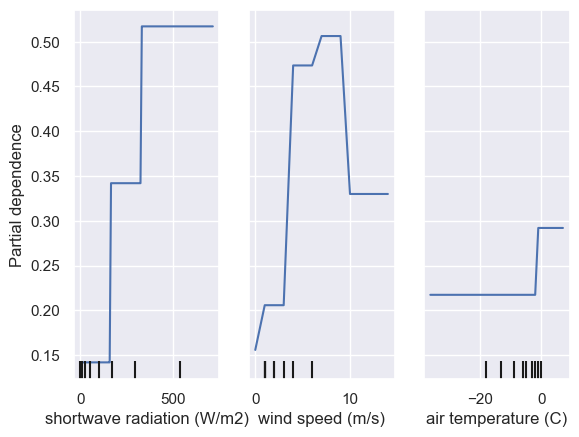

In [90]:
# increase the figure size 
# plt.figure(figsize=(20,6))
PartialDependenceDisplay.from_estimator(clf, X_train1, X.columns)

Computing partial dependence plots and individual conditional expectation...


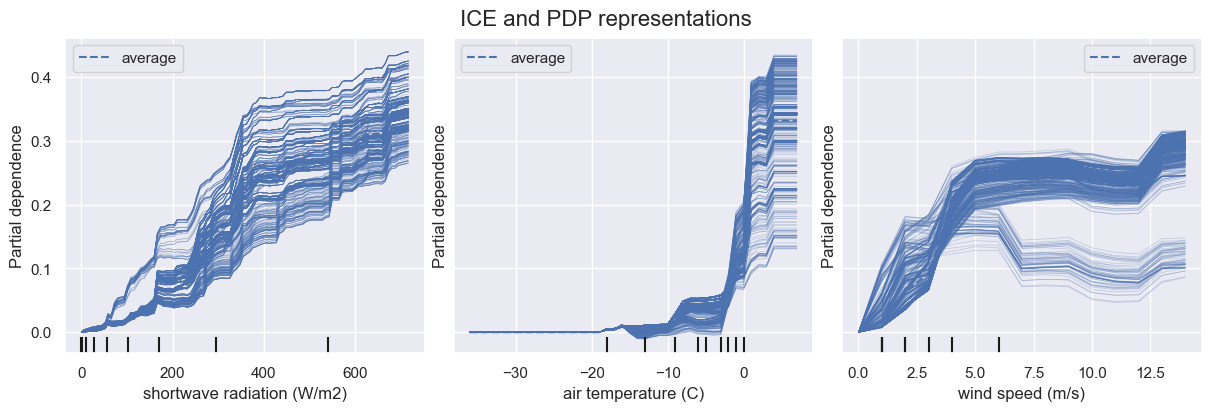

In [116]:
print("Computing partial dependence plots and individual conditional expectation...")

fig, ax = plt.subplots(ncols=3, figsize=(12, 4), sharey=True, constrained_layout=True)

features_info = {
    "features": [nameshortwave, nametemperature, namewindspeed],
    "kind": "both",
    "centered": True,  # Set to True if you want centered ICE curves
    
}

display = PartialDependenceDisplay.from_estimator(
    clf1,
    X_train1,
    **features_info,
    ax=ax,)

fig = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

Computing partial dependence plots and individual conditional expectation...


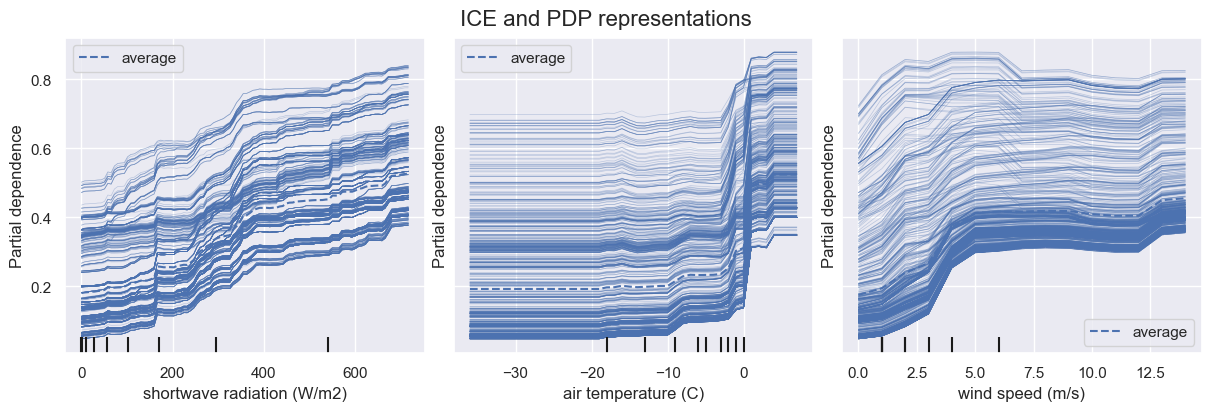

In [115]:
print("Computing partial dependence plots and individual conditional expectation...")

fig, ax = plt.subplots(ncols=3, figsize=(12, 4), sharey=True, constrained_layout=True)

features_info = {
    "features": [nameshortwave, nametemperature, namewindspeed],
    "kind": "both",
    "centered": False,  # Set to True if you want centered ICE curves
    
}

display = PartialDependenceDisplay.from_estimator(
    clf1,
    X_train1,
    **features_info,
    ax=ax,)

fig = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

Computing partial dependence plots...


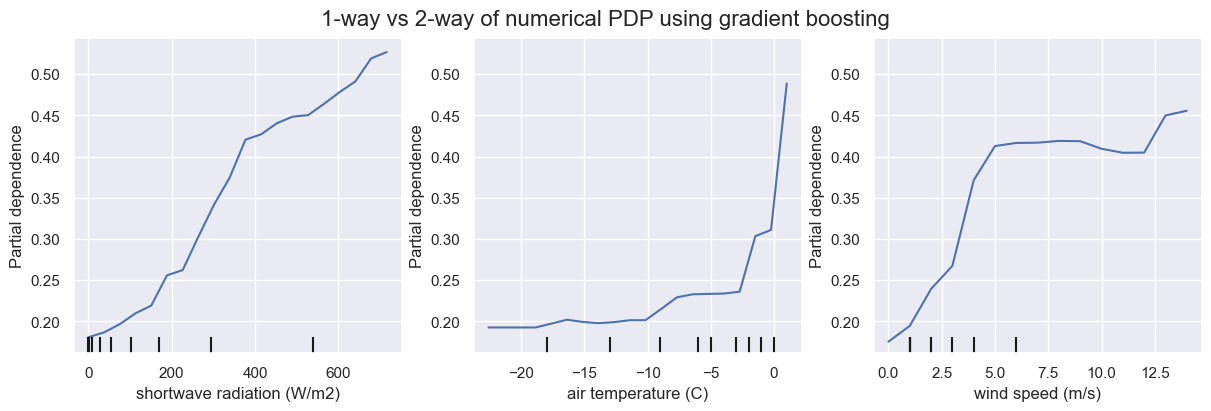

In [114]:
print("Computing partial dependence plots...")

features_info = {
    "features": [nameshortwave, nametemperature, namewindspeed],  # 2-way PDP
    "kind": "average",
}
fig, ax = plt.subplots(ncols=3, figsize=(12, 4), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    clf1,
    X_train1,
    **features_info,
    **common_params,
    ax=ax,   
)

fig = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16
)

Trying code directly from here right now...\
https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html

In [92]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

Computing partial dependence plots...


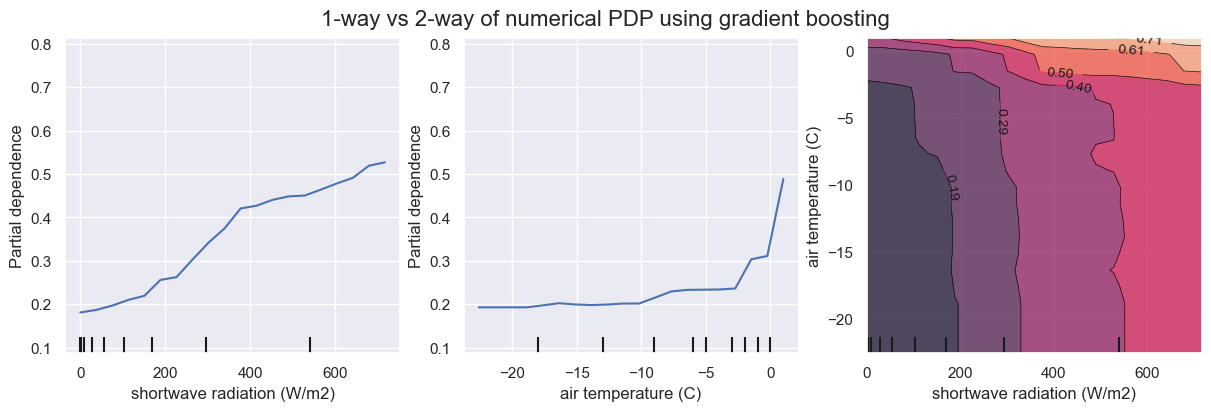

In [ ]:
print("Computing partial dependence plots...")

features_info = {
    "features": [nameshortwave, nametemperature, [nameshortwave, nametemperature]],  # 2-way PDP
    # "features": [nameshortwave, nametemperature, [nametemperature, nameshortwave]],  # if you want to flip the order
    "kind": "average",
}
fig, ax = plt.subplots(ncols=3, figsize=(12, 4), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    clf1,
    X_train1,
    **features_info,
    ax=ax,  
    **common_params 
)

fig = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16
)

Computing partial dependence plots...


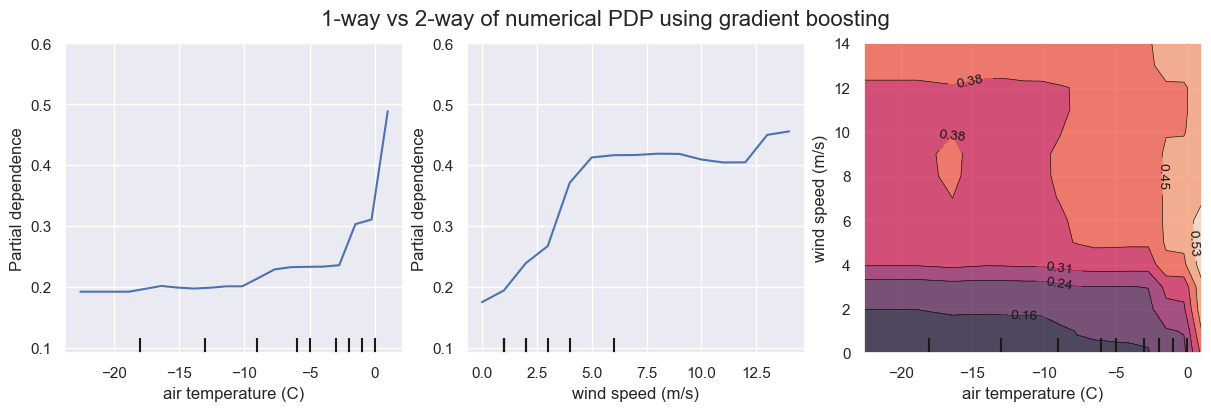

In [121]:
print("Computing partial dependence plots...")

features_info = {
    "features": [nametemperature, namewindspeed, [nametemperature, namewindspeed]],  # 2-way PDP
    # "features": [nametemperature, namewindspeed, [namewindspeed, nametemperature]],  # 2-way PDP
    "kind": "average",
}
fig, ax = plt.subplots(ncols=3, figsize=(12, 4), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    clf1,
    X_train1,
    **features_info,
    **common_params,
    ax=ax,   
)

fig = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16
)

Computing partial dependence plots...


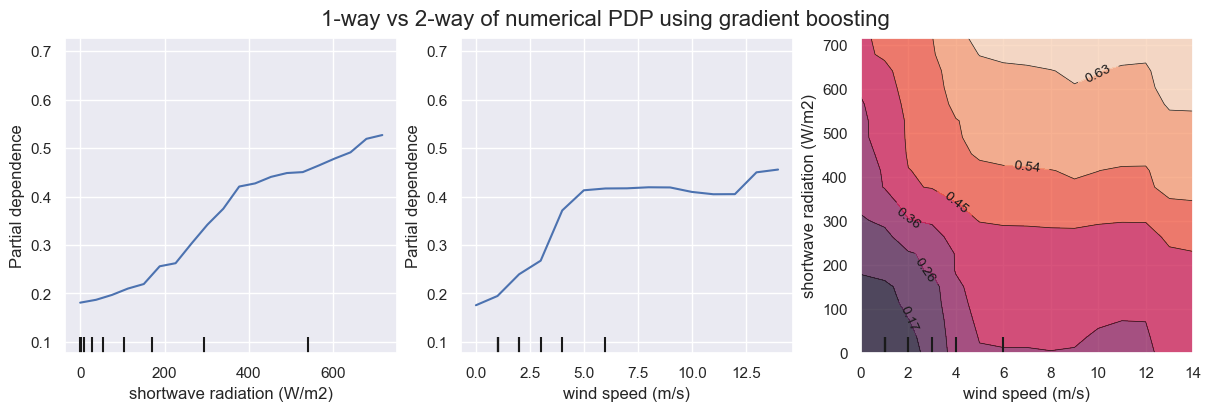

In [120]:
print("Computing partial dependence plots...")

features_info = {
    # "features": [nameshortwave, namewindspeed, [nameshortwave, namewindspeed]],  # 2-way PDP
    "features": [nameshortwave, namewindspeed, [namewindspeed, nameshortwave]],  # if you want to flip the plotting

    "kind": "average",
}
fig, ax = plt.subplots(ncols=3, figsize=(12, 4), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    clf1,
    X_train1,
    **features_info,
    **common_params,
    ax=ax,   
)

fig = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16
)

Try to plot all three 2-way models...

Computing partial dependence plots...


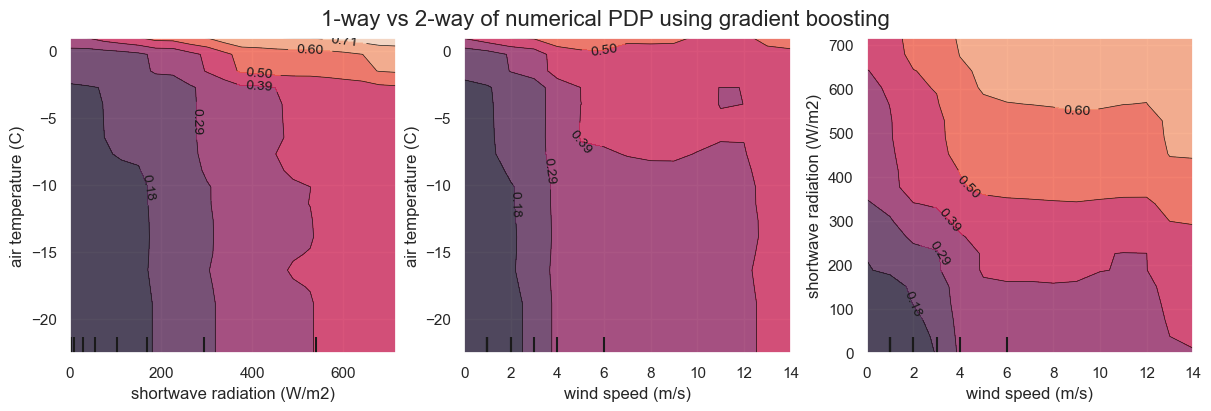

In [130]:
print("Computing partial dependence plots...")

features_info = {
    "features": [[nameshortwave, nametemperature], [namewindspeed, nametemperature], [namewindspeed, nameshortwave]],  # 2-way PDP

    "kind": "average",
}
fig, ax = plt.subplots(ncols=3, figsize=(12, 4), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    clf1,
    X_train1,
    **features_info,
    **common_params,
    ax=ax,   
)

fig = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16
)

# Now, let's look at Decision Trees

In [96]:
tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[0]]

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1292299738)

In [97]:
# bestDecisionTree1= tree_model1.estimators_[463] #first best
# bestDecisionTree2= tree_model1.estimators_[772] 

bestDecisionTree1= tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[0]]
bestDecisionTree2= tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[1]]
bestDecisionTree3= tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[2]]
bestDecisionTree4= tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[3]]
bestDecisionTree5= tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[4]]
bestDecisionTree6= tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[5]]
bestDecisionTree7= tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[6]]
bestDecisionTree8= tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[7]]
bestDecisionTree9= tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[8]]
bestDecisionTree10= tree_model1.estimators_[estimatorAccuracy['estimatorNumber'].values[9]]

### Decision Tree 2

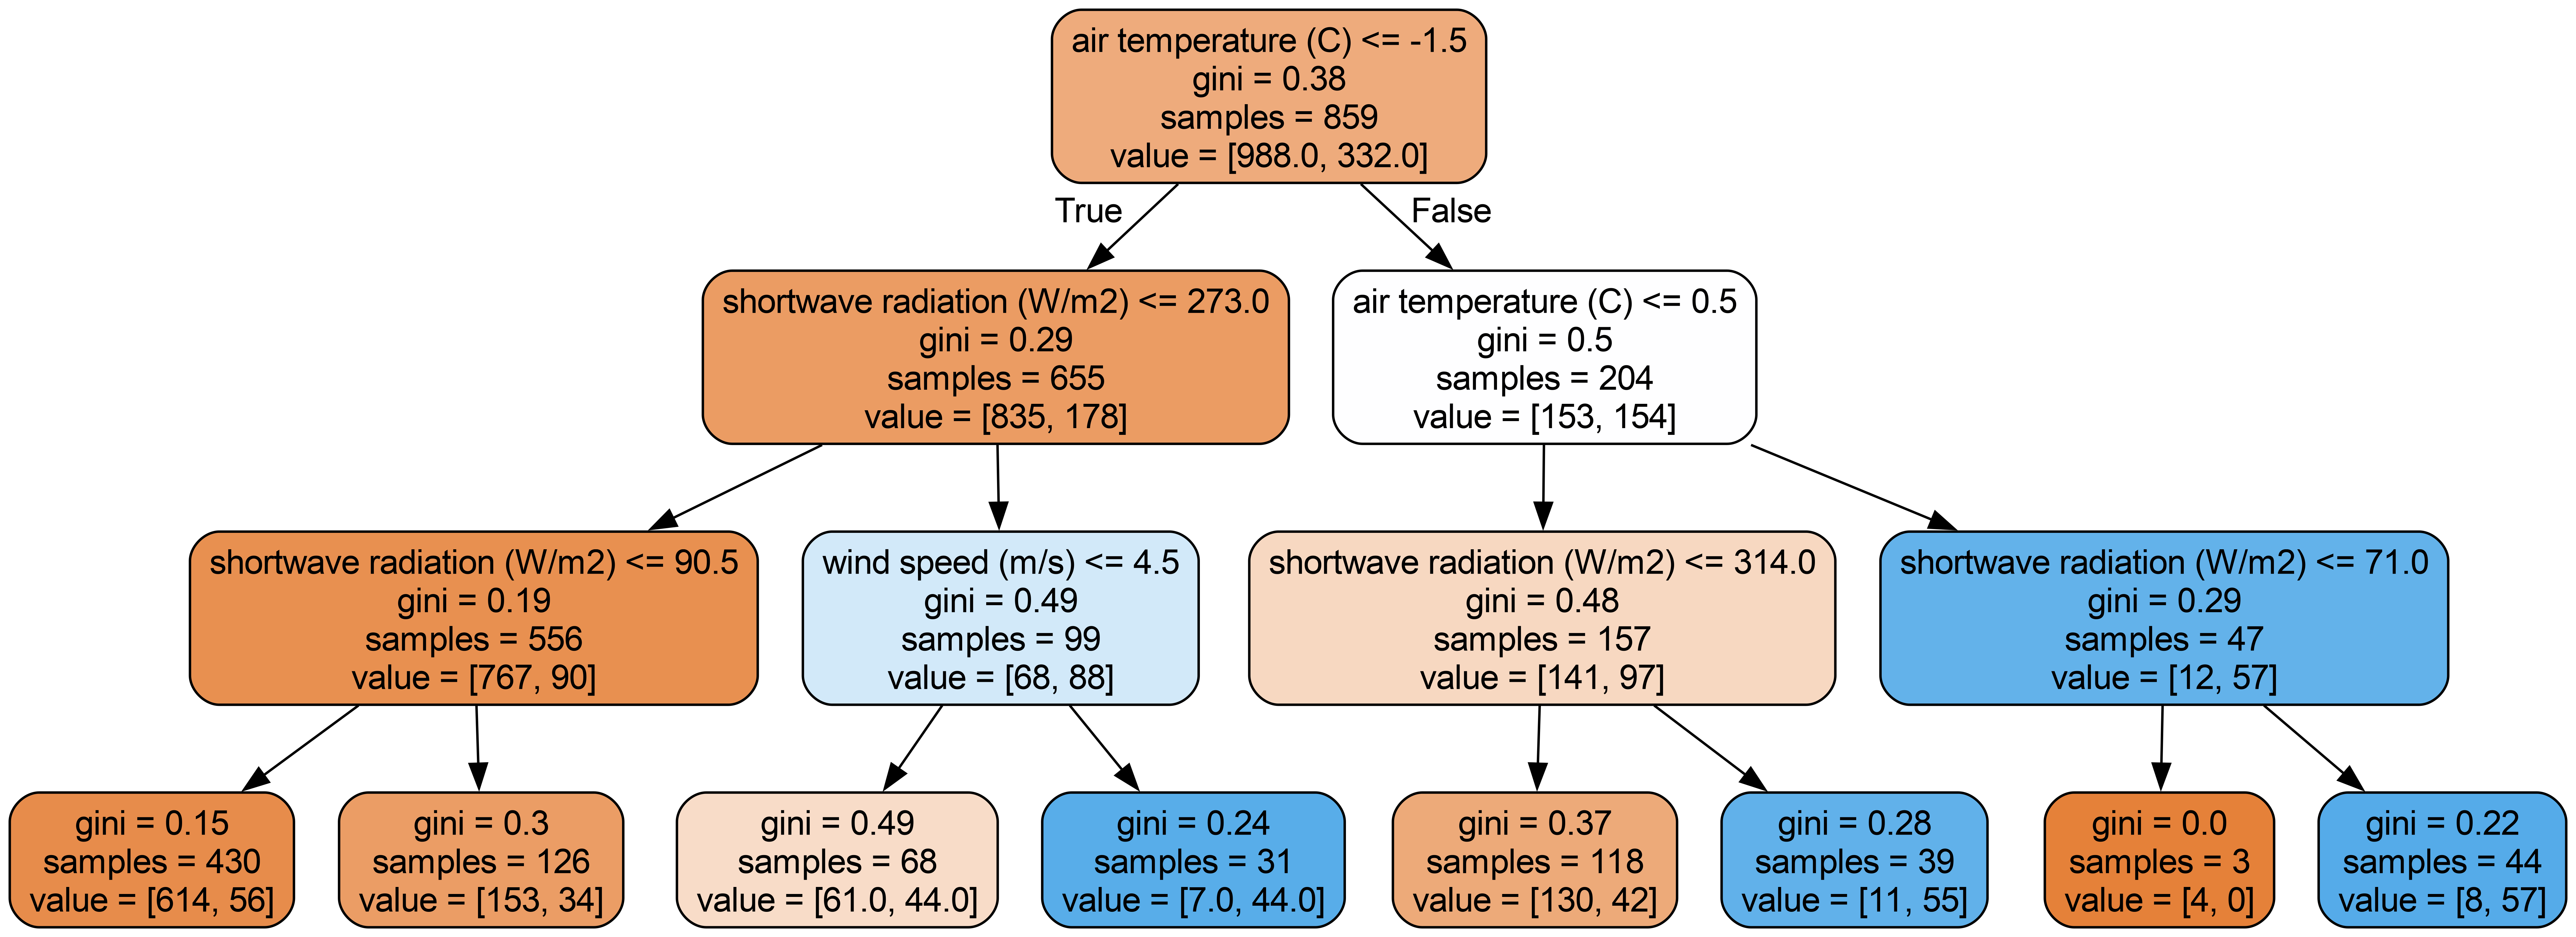

In [98]:
tree.export_graphviz(bestDecisionTree2, out_file='ensemble_tree2.dot', 
                feature_names = X.columns,
                # class_names = ('no_veg', 'veg'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'ensemble_tree2.dot', '-o', 'ensemble_tree2.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'ensemble_tree2.png')

Third best decision tree

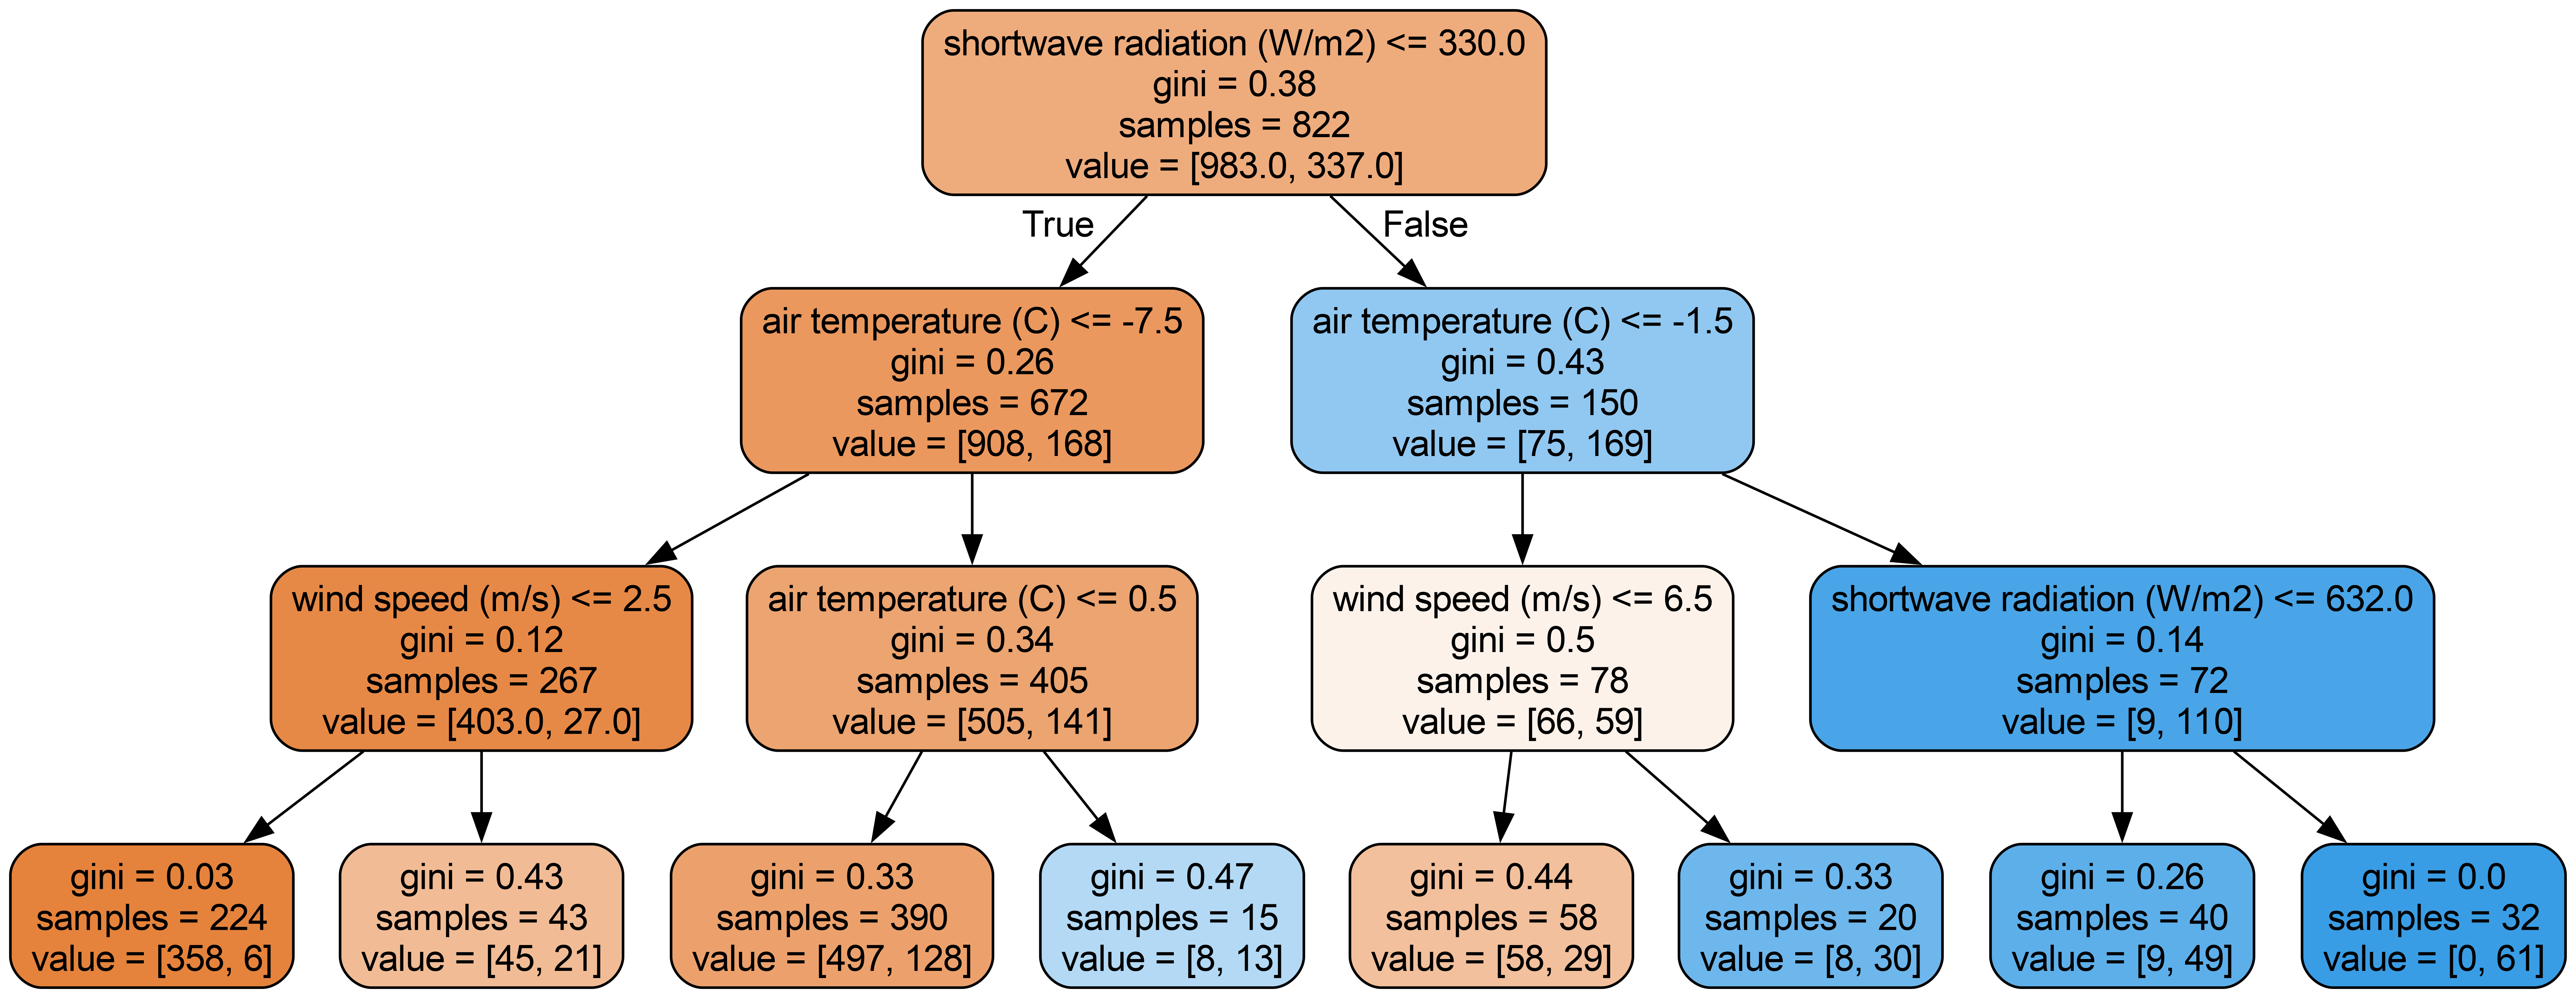

In [99]:
tree.export_graphviz(bestDecisionTree3, out_file='ensemble_tree3.dot', 
                feature_names = X.columns,
                # class_names = ('no_veg', 'veg'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'ensemble_tree3.dot', '-o', 'ensemble_tree3.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'ensemble_tree3.png')

## Now, loop through to save the top 50 decision trees 

In [100]:
from subprocess import call
from sklearn.tree import export_graphviz

In [101]:
# Create the folder if it doesn't exist
output_dir = 'updated_analysis_decision_trees_flip'
os.makedirs(output_dir, exist_ok=True)

top_n = 50

for i in range(top_n):
    tree_idx = estimatorAccuracy['estimatorNumber'].values[i]
    best_tree = tree_model1.estimators_[tree_idx]

    # Define file paths
    dot_filename = os.path.join(output_dir, f'ensemble_tree_{i+1:02d}.dot')
    png_filename = os.path.join(output_dir, f'ensemble_tree_{i+1:02d}.png')

    # Export to .dot
    export_graphviz(
        best_tree,
        out_file=dot_filename,
        feature_names=X.columns,
        rounded=True,
        proportion=False,
        precision=2,
        filled=True
    )

    # Convert to .png using Graphviz
    call(['dot', '-Tpng', dot_filename, '-o', png_filename, '-Gdpi=600'])

print("Done saving top 50 decision tree PNGs in 'updated_decision_trees'.")

Done saving top 50 decision tree PNGs in 'updated_decision_trees'.


## Save files to load in next notebook, `Updated_Analysis_Random_Forest_Read.ipynb`
so, we need to save the model to use it later 

In [123]:
tree_model1

RandomForestClassifier(max_depth=3, n_estimators=1000, n_jobs=15)

So I guess the pickle files have some problems now in newer versions, so let's save this model using `joblib`

In [124]:
from joblib import dump

In [125]:
filepath = '/home/cassie/data/unloading_regimes_analysis/'
# dump(tree_model1, filepath + 'updated_analysis_random_forest_model_int_20_1000.joblib')  # Save the model to a file
dump(tree_model1, filepath + 'updated_analysis_random_forest_model_int_20_1000_flip.joblib')  # Save the model to a file

# model = load('updated_analysis_random_forest_model_int_20_1000.joblib') # load it later 

['/home/cassie/data/unloading_regimes_analysis/updated_analysis_random_forest_model_int_20_1000_flip.joblib']

In [126]:
# We can also save this to a pickle file, like we did before 

filepath = '/home/cassie/data/unloading_regimes_analysis/'
# filename = 'updated_analysis_random_forest_model_int_20_1000.pkl' # random forest model with integers, trained on 20% of the data, 1000 trees
filename = 'updated_analysis_random_forest_model_int_20_1000_flip.pkl' # random forest model with integers, trained on 20% of the data, 1000 trees

pickle.dump(tree_model1, open(filepath + filename, 'wb')) # wb, writing 

# loaded_model = pickle.load(open(filename, 'rb')) # rb, reading 
# result = loaded_model.score(X_test, y_test)
# print(result)

Now, also save the simple dataframe we used to plot above for later

In [72]:
# df_int_sites # this is the dataframe with all the met data saved (as floats) with the CD column, sites, and model column added (int model)
# df_int_sites.to_csv('rfmodel_int_20_1000_results_with_metdata.csv') 
df_int_sites.to_csv(filepath + 'updated_analysis_random_forest_model_int_20_1000_results_with_metdata.csv') 